<img src="Imagenes/preparacion_datasett.jpg" alt="Imagen creada con inteligencia artificial y editada con Microsoft Paint" style="border-radius: 15px">


*Imagen creada con inteligencia artificial.*


## **INTRODUCCIÓN**

Como se ha visto en el **EDA** del dataset, no todas las etiquetas, es decir, las expresiones faciales, están igualmente representadas. Por ejemplo, en el datset de partida, la etiqueta 3 (**Felicidad**) tiene 8989 entradas, mientras que la etiqueta 1 (**Asco**) tiene tan solo 547 entradas.

Pese a que 547 podría parecer "no pocas" entradas, este desbalanceo puede suponer una merma importante en la calidad de un modelo. Lo ideal sería aumentar el dataset con más fotografías, pero esto es tedioso, lleva tiempo y no es lo más práctico.

La opción que aquí se muestra es crear fotografías nuevas a partir de las ya existentes, volteándolas horizontalmente, añadiendo algo de ruido y rotando un poco las **imagenes**. De esta forma, y haciéndolo según sea el desbalanceo, podemos conseguir un nuevo dataset algo más balanceado.  
  
Para cargaremos los tres datasets, los balancearemos individualmente y al final los uniremos en un dataset balanceado.

> Este notebook puede parecer algo complicado pero durante todo el notebook habrá explicaciones.
> 
> Sí, efectivamente, la imagen del banner es un guiño al hecho de que aquí se arreglan fotos.
> 
> Al final del notebook hay un resumen/explicación.



## **BIBLIOTECAS USADAS:**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import ast  
from scipy.ndimage import rotate

## **CARGA DEL DASET**

In [2]:
df_train = pd.read_csv('./datos/fer2013/dataframe_individuales/df_train.csv')
df_test= pd.read_csv('./datos/fer2013/dataframe_individuales/df_test.csv')
df_val= pd.read_csv('./datos/fer2013/dataframe_individuales/df_val.csv')

## **FLIP HORIZONTAL**

>Después del proceso de **data augmentation**, todas las clases tendrán la misma cantidad de **fotografías** (arrays en verdad).    
>Igualaremos el número de fotografías a la clase que más tiene, a esta, de momento, no le haremos nada.    
>Para las demás clases, haremos distintos procesos hasta que todas se igualen.  
>El primer proceso será un "flip horizontal.  


### **TRAIN**

In [3]:
df_train['emotion'].value_counts()

emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64

>Haremos **"flip"** a tantas entradas,lineas, por etiqueta de expresión facial como sea necesario para igualar la clase **"3"**.
>
>Las clases **"1"** y **"5"** necesitan otros procesos para poder tener suficiente cantidad.

In [4]:
def seleccionar_aleatoriamente(df, emotion, n):
    return df[df['emotion'] == emotion].sample(n=n, random_state=42)
df_emotion_6 = seleccionar_aleatoriamente(df_train, 6,2250)
df_emotion_4 = seleccionar_aleatoriamente(df_train, 4,2385)
df_emotion_2 = seleccionar_aleatoriamente(df_train, 2, 3118)
df_emotion_0 = seleccionar_aleatoriamente(df_train, 0, 3220)
df_emotion_5 = df_train[df_train['emotion'] == 5]
df_emotion_1 = df_train[df_train['emotion'] == 1]
df_train_espejo = pd.concat([df_emotion_6, df_emotion_4, df_emotion_2, df_emotion_0, df_emotion_5, df_emotion_1])
df_train_espejo = df_train_espejo.reset_index(drop=True) 


In [5]:
df_train_espejo['emotion'].value_counts()

emotion
0    3220
5    3171
2    3118
4    2385
6    2250
1     436
Name: count, dtype: int64

>**Vemos que si sumamos estas y los conteos de los datasets, tenemos que las clases se equilibran (excepto las dos más desfavorecidas)... en otras palabras, vamos bien.**

### **TEST**

In [6]:
df_test['emotion'].value_counts()

emotion
3    895
4    653
6    607
2    496
0    467
5    415
1     56
Name: count, dtype: int64

In [7]:
df_emotion_4_test = seleccionar_aleatoriamente(df_test, 4, 242)
df_emotion_6_test = seleccionar_aleatoriamente(df_test, 6,288)
df_emotion_2_test = seleccionar_aleatoriamente(df_test, 2, 399)
df_emotion_0_test = seleccionar_aleatoriamente(df_test, 0, 428)
df_emotion_5_test = df_test[df_test['emotion'] == 5]
df_emotion_1_test = df_test[df_test['emotion'] == 1]
df_test_espejo = pd.concat([df_emotion_6_test, df_emotion_4_test, df_emotion_2_test, df_emotion_0_test, df_emotion_5_test, df_emotion_1_test])
df_test_espejo = df_test_espejo.reset_index(drop=True) 

In [8]:
df_test_espejo['emotion'].value_counts()

emotion
0    428
5    415
2    399
6    288
4    242
1     56
Name: count, dtype: int64

### **VAL**

In [9]:
df_val['emotion'].value_counts()

emotion
3    879
6    626
4    594
2    528
0    491
5    416
1     55
Name: count, dtype: int64

In [10]:
df_emotion_6_val = seleccionar_aleatoriamente(df_val, 6, 253)
df_emotion_4_val = seleccionar_aleatoriamente(df_val, 4, 281)
df_emotion_2_val = seleccionar_aleatoriamente(df_val, 2, 351)
df_emotion_0_val = seleccionar_aleatoriamente(df_val, 0, 388)
df_emotion_5_val = df_val[df_val['emotion'] == 5]
df_emotion_1_val = df_val[df_val['emotion'] == 1]
df_val_espejo = pd.concat([df_emotion_6_val, df_emotion_4_val, df_emotion_2_val, df_emotion_0_val, df_emotion_5_val, df_emotion_1_val])
df_val_espejo = df_val_espejo.reset_index(drop=True)


In [11]:
df_val_espejo['emotion'].value_counts()

emotion
5    416
0    388
2    351
4    281
6    253
1     55
Name: count, dtype: int64

In [12]:
def flip_image_horizontal(pixel_string):
    try:
        pixel_values = list(map(int, pixel_string.split()))
        size = int(np.sqrt(len(pixel_values)))
        image_matrix = np.array(pixel_values).reshape((size, size))
        flipped_image_matrix = np.fliplr(image_matrix)
        flipped_pixel_string = ' '.join(map(str, flipped_image_matrix.flatten()))
        return flipped_pixel_string
    except Exception as e:
        print(f"Error al procesar la imagen: {e}")
        return pixel_string  # Devuelve la cadena original en caso de error



>**Aquí definimos la función que dará la vuelta horizontalmente a las fotografías (realmente se la da a la cadena).**


In [13]:
df_train_espejo.loc[:, 'pixels'] = df_train_espejo['pixels'].apply(lambda x: flip_image_horizontal(x))
df_test_espejo.loc[:, 'pixels'] = df_test_espejo['pixels'].apply(lambda x: flip_image_horizontal(x))
df_val_espejo.loc[:, 'pixels'] = df_val_espejo['pixels'].apply(lambda x: flip_image_horizontal(x))

> **Y con estas llamadas a la función, le damos la vuelta a las líneas que habíamos elegido antes.**

### **VISUALIZACIÓN.**  
> **Visualizaremos las imágenes para verificar si ha ido bien. Primero las visualizaremos sin el flip y luego con el flip. Dado que las imágenes que han sido volteadas en las clases menos desfavorecidas se han elegido aleatoriamente, solo observaremos esto en las clases más desfavorecidas (que se han volteado completamente).**


In [25]:
emotion_labels = {0: 'Enfado',1: 'Asco',2: 'Miedo',3: 'Felicidad',4: 'Tristeza',5: 'Sorpresa',6: 'Neutral'}#No es necesario visualizar todas las clases para ver que ha ido bien.
def mostrar_imagenes_emocion(df, emotion):
    filtered_df = df[df['emotion'] == emotion].head(3)  
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle(f'Emoción: {emotion_labels[emotion]}', fontsize=16)  
    for i, ax in enumerate(axes):
        if i < len(filtered_df):
            pixels = np.array(filtered_df.iloc[i]['pixels'].split(), dtype='int').reshape(48, 48)
            ax.imshow(pixels, cmap='gray')
            ax.axis('off')   
    plt.tight_layout()
    plt.show()



> **Esta función nos mostrará las imágenes.**

## **SIN VOLTEAR**

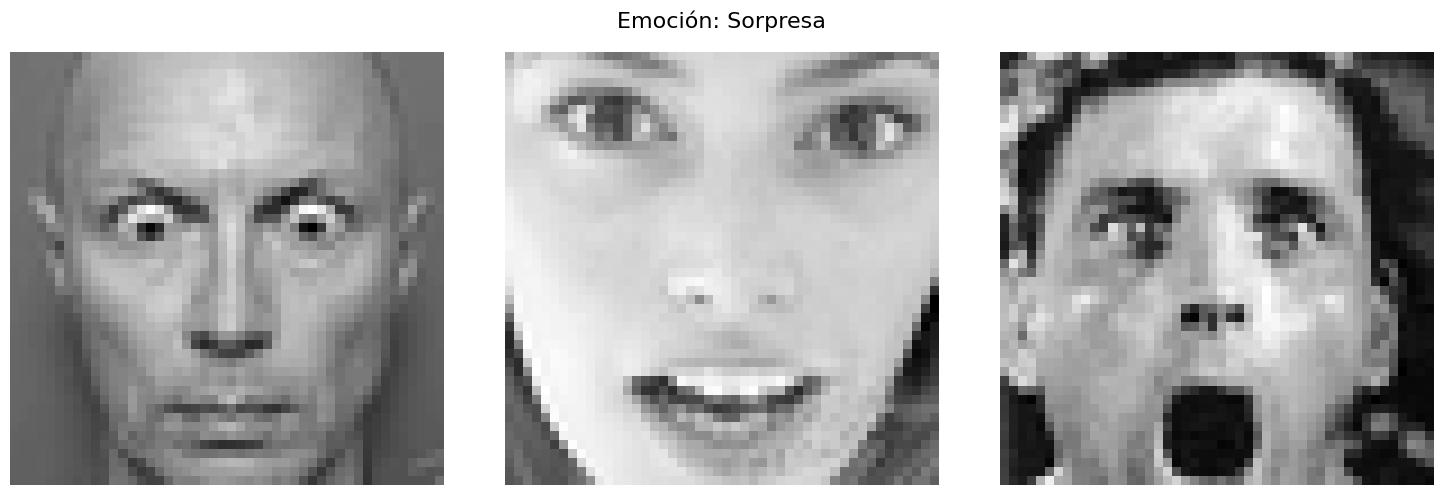

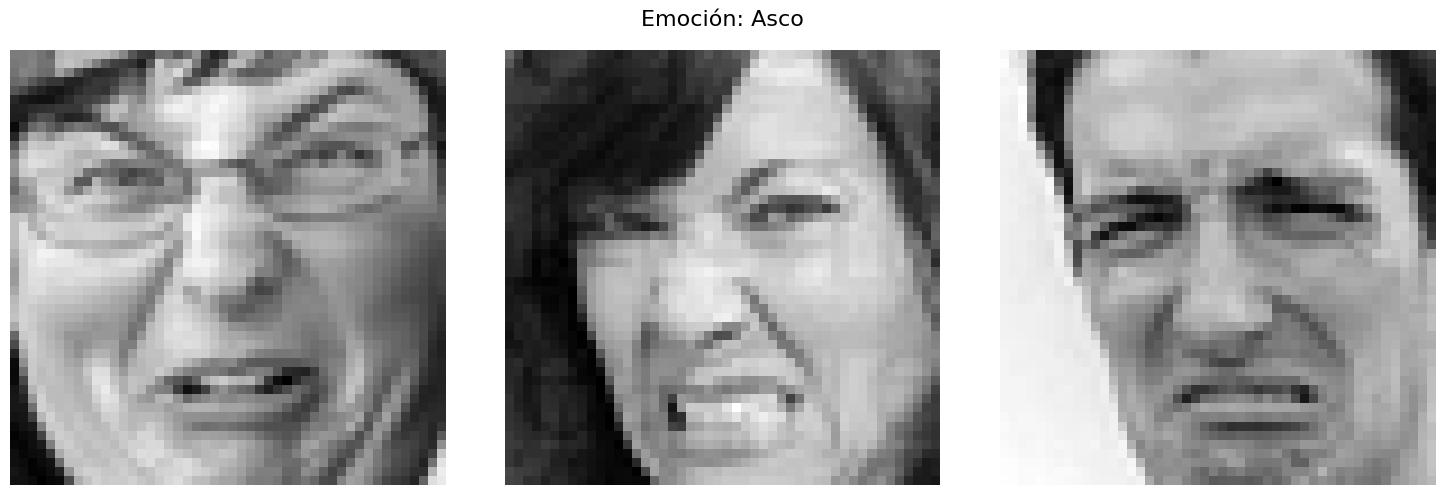

In [27]:
for emotion in [ 5, 1]:
    mostrar_imagenes_emocion(df_train, emotion)


## **VOLTEADAS**

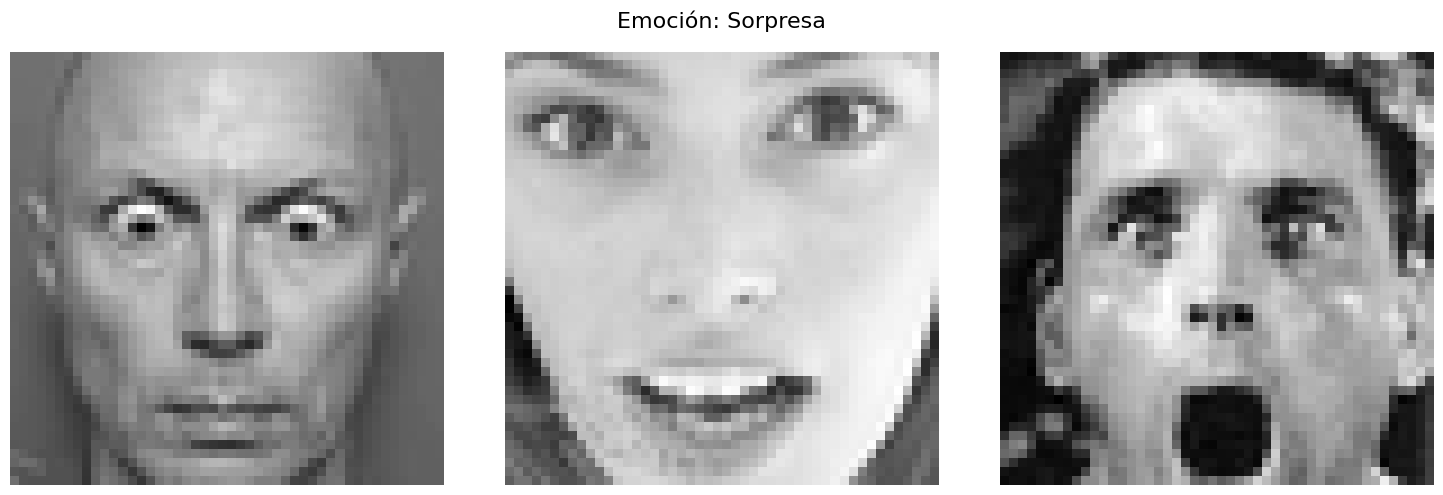

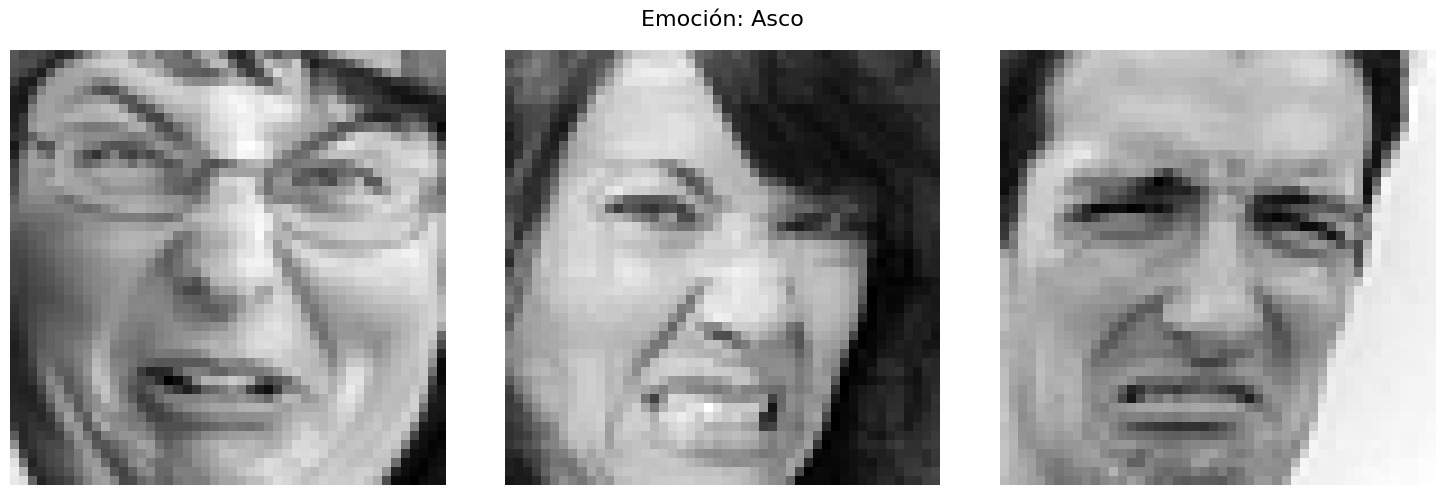

In [28]:
for emotion in [ 5, 1]:
    mostrar_imagenes_emocion(df_train_espejo, emotion)

> **Hemos comprobado que el volteo ha sido exitoso. Ahora podemos unir los datasets volteados con sus respectivos sin voltear.**


## **UNIÓN DE LOS DATASETS VOLTEADOS CON LOS DATASETS ORIGINALES**

In [29]:
df_train = pd.concat([df_train_espejo, df_train], ignore_index=True)
df_test = pd.concat([df_test_espejo, df_test], ignore_index=True)
df_val = pd.concat([df_val_espejo, df_val], ignore_index=True)

### **COMPROBAMOS**

In [32]:
print("El dataset de entenamiento ha quedado así:")
print(df_train['emotion'].value_counts())
print()
print("El dataset de validación ha quedado así:")
print(df_val['emotion'].value_counts())
print()
print("El dataset pruebas ha quedado así:")
print(df_test['emotion'].value_counts())




El dataset de entenamiento ha quedado así:
emotion
6    7215
4    7215
2    7215
0    7215
3    7215
5    6342
1     872
Name: count, dtype: int64

El dataset de validación ha quedado así:
emotion
6    879
2    879
0    879
3    879
4    875
5    832
1    110
Name: count, dtype: int64

El dataset pruebas ha quedado así:
emotion
6    895
4    895
2    895
0    895
3    895
5    830
1    112
Name: count, dtype: int64


>**Vemos que solo las clases 1 (Asco/disgusto) y 5 (Sorpresa) están descompensadas. La clase 5 está poco descompensada, mientras que la clase 1 está bastante descompensada.**   **¿Qué significa esto? Significa que vamos bien.**